# Estimate N_ext from the offshore data

In [1]:
import numpy as np
import scipy as sp
from scipy.integrate import odeint
from scipy import interpolate
import matplotlib.pyplot as plt
import pandas as pd
# print(f"pandas version is {pd.__version__}")
from array import *
%matplotlib inline

from local_functions import Time_to_Hours

import datetime

In [2]:
# Read data from excel file
x2 = pd.ExcelFile('../data/Data.xlsx')

In [3]:
# Constant parameters for model:
n_reactors = 1
umol_to_percent_DW = 0.0014
miu = 0.03
Nintmin = 0.48
Z = 0.085
Tmin = 4.0
teta = 1.047
dNextindt = 0.0
dmoutdt = 0.0

In [4]:
# load indoor calibration data
X = np.loadtxt('indoor_calibration.txt')

#miu = 0.03

losses20 = X[0]
Nintmax = X[1]
Nintcrit = X[2]
dNextoutdt = X[3]
Ks = X[4]
Vmax = X[5]
KI = X[6]
K0 = X[7]
Ka = X[8]

# load brine calibration data

X = np.loadtxt('brine_calibration.txt') 

['Smin','Sopt','Smax','Topt','Tmax','n']


Smin = X[0]
Sopt = X[1]
Smax = X[2]

Topt = X[3]
Tmax = X[4]
n = X[5]



In [5]:
# Import offshore data into df4
df4 = x2.parse('Offshore')

In [6]:
# Convert Time into hours
T = []
for i in df4['Sample'][:]:
    T1 = df4['Timeh'][df4['Sample'].values.tolist().index(i)]
    T2 = df4['Time'][df4['Sample'].values.tolist().index(i)]
    T.append(Time_to_Hours(T1,T2))
    
df4.loc[:,'T'] = T

Tm = []
for i in df4['Sample'][:]:
    T1 = df4['Timem'][df4['Sample'].values.tolist().index(i)]
    T2 = df4['Time'][df4['Sample'].values.tolist().index(i)]
    Tm.append(Time_to_Hours(T1,T2))
    
df4.loc[:,'Tm'] = Tm

In [7]:
'''
Make a reduced DF by filtering the original df to focus on:
Depth: 5m
Fertilizing before cultivation experiment: continuous (long duration)
Cultivation length: ~7 days
Experiments: 2-5
Remove experiments with complete biomass loss

'''
df4f = df4[(df4.Stage == 'f')]
df4i = df4[(df4.Stage == 'i')]
df4f = df4f.assign(Ni = df4i.N.values)

df4Reduced = df4f[(np.isnan(df4f.DW) != True)&(df4f.Stage == 'f') & (df4f.Depth == 5) & (df4f.Exp != 1) & (df4f.Period == 'Continuous') & (df4f.Days != 12)]
df4Reduced.head()

,Sample,Exp,Period,Cage,Depth,Stage,Days,Timei,Timeh,Timem,...,DGR,RGR,GR,Treatment,Comment,Comment 2,N_Saturation,T,Tm,Ni
62,53.7,2,Continuous,13,5,f,NaN,"2019,7,22,11,0","2019,7,22,11,0","2019,7,22,11,0",...,0.077470,6.189534,6.385100,1000 / 7 / 18,fertilization in a 35 liter container,NaN,no,170,170,1.76
63,54.7,2,Continuous,14,5,f,NaN,"2019,7,22,11,0","2019,7,22,11,0","2019,7,22,11,0",...,0.177315,11.528773,12.219628,1000 / 7 / 18,fertilization in a 35 liter container,NaN,no,170,170,NaN
64,55.7,2,Continuous,15,5,f,NaN,"2019,7,22,11,0","2019,7,22,11,0","2019,7,22,11,0",...,0.192143,12.175506,12.947741,1000 / 7 / 18,fertilization in a 35 liter container,NaN,no,170,170,NaN
65,56.7,2,Continuous,16,5,f,NaN,"2019,7,22,11,0","2019,7,22,11,0","2019,7,22,11,0",...,0.124470,8.951807,9.364710,NaN,NaN,NaN,no,170,170,NaN
66,57.7,2,Continuous,17,5,f,NaN,"2019,7,22,11,0","2019,7,22,11,0","2019,7,22,11,0",...,0.129353,9.210430,9.647918,NaN,NaN,NaN,no,170,170,NaN


In [8]:
# Build interpolations functions for temperature data

xCTD = pd.ExcelFile('../data/CTDr.xlsx')
dfCTD = xCTD.parse('HaderaCTD',header=None)

dfCTD.head()

,0,1,2,3,4,5,6,7,8,9,10
0,time_ISO8601 [yyyy-mm-ddThh:mm:ss:sss],Year,Month,Day,Time,Date&Time,WaterTemp [degC],Depth [m],Longitude [degrees_east],Latitude [degrees_north,Bot. Depth [m]
1,2019-07-22T00:01:03,2019,07,22,00:01:03,2019-07-22 00:01:03,29.7534,12,1,NaN,NaN
2,2019-07-22T00:11:04,2019,07,22,00:11:04,2019-07-22 00:11:04,29.6921,12,2,NaN,NaN
3,2019-07-22T00:21:03,2019,07,22,00:21:03,2019-07-22 00:21:03,29.7344,12,3,NaN,NaN
4,2019-07-22T00:31:04,2019,07,22,00:31:04,2019-07-22 00:31:04,29.6629,12,4,NaN,NaN


In [9]:
# Import water temperature data

Twater = dfCTD.iloc[1:42624:1][6].values 

# TCTD = dfCTD.iloc[1:42624:1][6]
# Twater = []
# for i in TCTD:
#     #if type(i) == int:
#     #    i = str(i)
#     Twater.append(i)#float(re.sub(r"\s+", "", i, flags=re.UNICODE)))

In [10]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [11]:
# T_average is a moving average of 1 hour with jumps of 1 hours (6 times 10 minutes)

T_average = moving_average(Twater[::6],6)


In [12]:
#plt.plot(moving_average(Twater[1::6],6),'r',alpha=.3)
#plt.plot(T_average,'b',alpha=.2)

In [13]:
# Build interpolations functions for temperature and light IMS data
# Import combined IMS excel for light function
dfims = pd.read_csv('../data/ims.csv',encoding= 'unicode_escape',header=None)


# days = list(range(1,296))
days = np.arange(1,296) # or from day 0? np.arange(296)

I_plot = np.zeros(24*296)
light_hours = np.arange(5,19)
for day in days:
    for hour in light_hours:
        I_plot[(day-1)*24 + hour] = float(dfims.iloc[day][hour-1])


all_hours = np.arange(1,296*24+1)

fI0 = interpolate.interp1d(all_hours, I_plot,kind = 'linear',bounds_error=False, fill_value="extrapolate")

In [14]:
def Offshore_constant_N_new(x,t,Nintmax,Nintmin,Vmax,Ks,dNextoutdt,dNextindt,miu,dmoutdt,Nintcrit,S,Z,KI,K0,Ka,Topt,
                Tmin,Tmax,losses20,teta,Sopt,Smin,Smax,n,umol_to_percent_DW,fTemp0,fI0,VA):


    Next = x[0] #x[0] # units: [umol N/l]
    Nint = x[1] # units: [% g N/g DW]
    m = x[2] # units: [g DW/l]
    
    Neff = (Nintmax - Nint)/(Nintmax - Nintmin)  # units: [ ]
    if Next <= 0:
        uN = 0
    else: 
        uN = Vmax * Next / (Ks + Next)  # units: [umol N/g DW/h]
    if Nint >= Nintcrit:
        fN = 1
    else:
        fN = ((Nint - Nintmin)/Nint) / ((Nintcrit - Nintmin)/Nintcrit)  # units: [ ]
    fP = 1  #(N:P < 12)


    # density - light penetration effects:
    SD = m * VA # Stocking Density. units: [g DW/ m^2]
    I0 = fI0(t)
    #print('I0 is : ' + str(I0))
    I_average = (I0 - K0 * Z) / (Ka * SD) * (1 - np.exp(-(Ka * SD)))
    fI = I_average / (I_average + KI) # units: [-]

    # Add Z effect on I
    Temp = fTemp0(t)
        # Temperature effects:         
    if Temp <= Topt:
        Tx = Tmin
    else:
        Tx = Tmax

    fT = np.exp(-2.3 * ((Temp - Topt) / (Tx - Topt))**n) # Temp from temperature data

    # S (salinity) effects
    if S < Sopt:
        Sx = Smin
        b = 2.5
        if S < 5:
            fS = ((S - Smin)/(Sopt - Sx))
        elif S >= 5:
            fS = 1 - ((S - Sopt)/(Sx - Sopt)) ** b           
    elif S >= Sopt:
        Sx = Smax
        b = 4.4 # found by solver in fs file
        fS = 1 - ((S - Sopt)/(Sx - Sopt)) ** b

    # empirically defined losses
    losses = losses20 * teta ** (Temp - 20)

    # limiting factors:
    g = min(fN,fI,fP) * fT * fS

    
    umol_to_percent_DW = 100*14e-6 #[% g N/umol N] 
    
    # Reactor Next -> Nint -> m and feedback

    dNextdt = 0 # [umol N/l/h]
    dNintdt = umol_to_percent_DW * Neff * uN - Nint * miu * g #units: [%g N/g DW/h]

    if fI == 0:
        losses = 0
    dmdt = (miu * g - losses) * m #units: [g DW/l/h]
        
    return [dNextdt,dNintdt,dmdt]

In [15]:
#Offshore plots - reverse calculate Next values, without winter experiment (Losses due to storm)

mmod_all,mSRE3Exp,Nintmod_all,NintSRE3Exp = [],[],[],[]
mSRE3, NintSRE3 = [], []
mmodAll, mSRE3All, NintmodAll, NintSRE3All = [],[],[],[]
Experiments = [2,3,5]
xlabels_all = [['22 July','26 July', '29 July'],['30 Oct','3 Nov', '6 Nov'],['30 Apr', '6 May','12 May'],]

# we shall run the model in this range:
# 0 - 7.8
m_0 = (20 / 1.44) * 0.15
Nint_0_all = [1.76, 1.19, 1.88]
VA = 1.44 / (0.3 * 0.15) # units: [g DW/ m^2] # A = w*l - conversion from volumetric to areal units
Z = 5 # m - depth of cages in water

def residual(Next_0, i=i, plot_on = False):

# for i in Experiments:
    All_RMSREm3,All_RMSRENint3 = [],[]
    mSRE3Exp,NintSRE3Exp = [],[]
    DATA = []
    xlabels = xlabels_all[Experiments.index(i)]

    df4Temp = df4Reduced[(df4Reduced.Exp == i)] 
    Samples = df4Temp.Sample.values
    Nint_0 = Nint_0_all[Experiments.index(i)]

    t = np.arange(df4Temp['T'].values[0])
    T1 = '2019,07,22,0,0'
    T2 = df4Temp['Timei']
    T2 = T2.tolist()[0]
    t0 = Time_to_Hours(T1,T2)

    # light function
    I_reduced = I_plot[t0:t0+t[-1]+1]
    fI0 = interpolate.interp1d(t, I_reduced,kind = 'linear', bounds_error=False, fill_value="extrapolate")

    # T function
    T_reduced = T_average[t0:t0+t[-1]+1] 

    fTemp0 = interpolate.interp1d(t, T_reduced,kind = 'linear', bounds_error=False, fill_value="extrapolate")

    NEXT, NINT, M, TT = [],[],[],[]
    x0 = [Next_0,Nint_0,m_0]  

    # model simulation

    # setup initial conditions

    x = odeint(Offshore_constant_N_new,x0,t,args=(Nintmax,Nintmin,Vmax,Ks,dNextoutdt,dNextindt,miu,dmoutdt,Nintcrit,Sopt,Z,KI,K0,Ka,
                                        Topt,Tmin,Tmax,losses20,teta,Sopt,Smin,Smax,n,umol_to_percent_DW,fTemp0,fI0,VA))

    NEXT.append(x[: , 0]) #
    NINT.append(x[: , 1]) #
    M.append(x[: , 2])    #
    TT.append(t)

    t_model = np.hstack(TT)
    Next_model = np.hstack(NEXT)
    Nint_model = np.hstack(NINT)
    m_model = np.hstack(M)


    mmod_all.append(m_model[-1])
    Nintmod_all.append(Nint_model[-1])


    if plot_on:
        # plot I and T
        fig2, ax2 = plt.subplots(2,1,figsize=(13,6))
        ax2[0].plot(t,T_reduced,'.',markersize=3,color='black')
        ax2[1].plot(t,I_reduced,'.',markersize=3,color='k')

        ax2[0].set_ylabel('Temperature \n[C]',fontsize=11, weight="bold")
        ax2[1].set_ylabel('Light Intensity \n[µmol photons $m^{-2}$ $second^{-1}$]',fontsize=11, weight="bold")

        ax2[0].set_xticklabels([])
        ax2[1].set_xticklabels([])
        ax2[1].set_xticks(t[0:len(t):int(len(t)/2-1)])
        ax2[1].set_xticklabels([str(i) for i in xlabels], rotation=45,fontsize=10, weight="bold")
        
        # plot model
        fig, ax = plt.subplots(2,1,figsize=(13,8))
        ax[0].plot(t,NINT[-1],linestyle = '--',markersize=3.5,color='green')
        ax[0].set_ylim([0,3])
        ax[1].plot(t,M[-1],linestyle = '--',markersize=3.5,color='blue')
        ax[1].set_ylim([1.5,9])
        #col = len(l)
        ax[0].legend(Experiments,loc='lower left',fontsize='medium',markerscale=2,columnspacing = 0.2,handletextpad = 0.3)#,edgecolor='white')
            


    mexp_Temp,Nintexp_Temp = [],[]
    for j in Samples:

        mexp = df4Temp[df4Temp.Sample == j].DW
        mexp = mexp.tolist()[0]
        mexp_Temp.append(mexp)
        Nintexp = df4Temp[df4Temp.Sample == j].N
        Nintexp = Nintexp.tolist()[0]
        Nintexp_Temp.append(Nintexp)  

        mSRE3Exp.append(((mexp-mmod_all[-1])/mmod_all[-1])**2)
        NintSRE3Exp.append(((Nintexp-Nintmod_all[-1])/Nintmod_all[-1])**2)
        
        if plot_on:
            ax[1].plot(t[-1],mexp,'*',markersize = 6,color='blue')
            ax[0].plot(t[-1],Nintexp,'*',markersize = 6,color='green')
       

    data = {'T':T[0],'Next':NEXT[0],'Nint':NINT[0],'m':M[0]}
    DATA.append(data)

    if plot_on:
        ax[0].set_xticklabels([])
        ax[1].set_xticklabels([])
        ax[1].set_xticks(t[0:len(t):int(len(t)/2-1)])
        ax[1].set_xticklabels([str(i) for i in xlabels], rotation=45,fontsize=10, weight="bold")

        ax[0].set_ylabel('Nint \n [% g N $g^{-1}$ DW]',fontsize=12, weight="bold")
        ax[1].set_ylabel('m \n [g FW $L^{-1}$]',fontsize=12, weight="bold")

        plt.tight_layout()
    

    mSRE3All.append(mSRE3Exp)
    NintSRE3All.append(NintSRE3Exp)


    RMSREm3 = round((np.mean(mSRE3Exp))**0.5,3)
    cleanedNintSRE3 = [x for x in NintSRE3Exp if str(x) != 'nan']
    RMSRENint3 = round((np.mean(cleanedNintSRE3))**0.5,3)
    All_RMSREm3.append(RMSREm3)
    All_RMSRENint3.append(RMSRENint3)

    return np.mean(np.array(All_RMSREm3)**2 + np.array(All_RMSRENint3)**2)

In [16]:
from scipy.optimize import minimize_scalar, Bounds

Next_estimate = []

for i in Experiments:
    sol = minimize_scalar(residual, method='bounded', bounds = (0.0, 8.0), args=(i, False))
    print(sol.x)
    Next_estimate.append(sol.x)

1.0810309958957445
1.6717303769458727
3.345811831956913


In [17]:
np.savetxt('offshore_Next_estimate.txt',Next_estimate)
np.savetxt('offshore_experiments.txt',Experiments)

 Next, experiment: (1.0810309958957445, 2)
 Next, experiment: (1.6717303769458727, 3)
 Next, experiment: (3.345811831956913, 5)


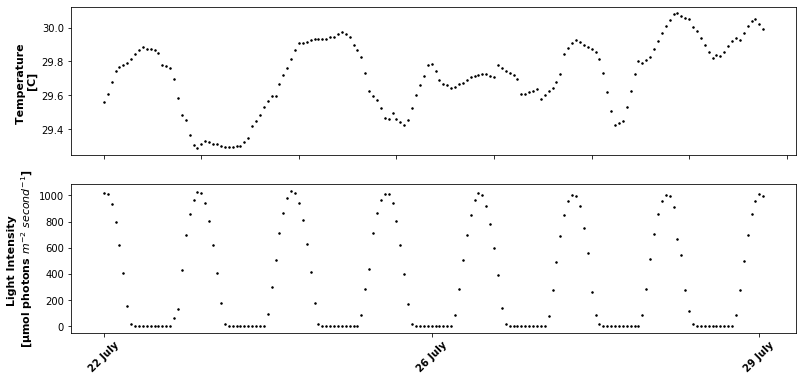

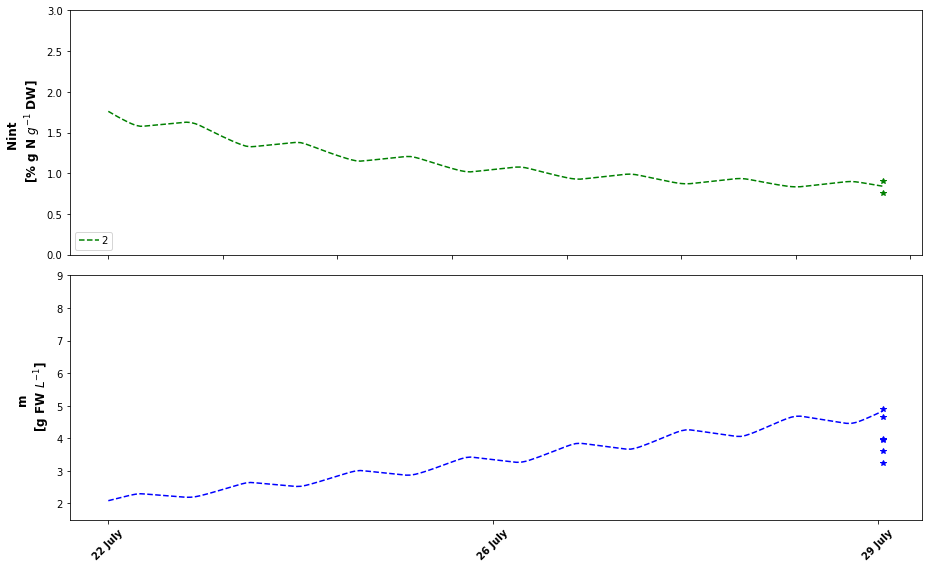

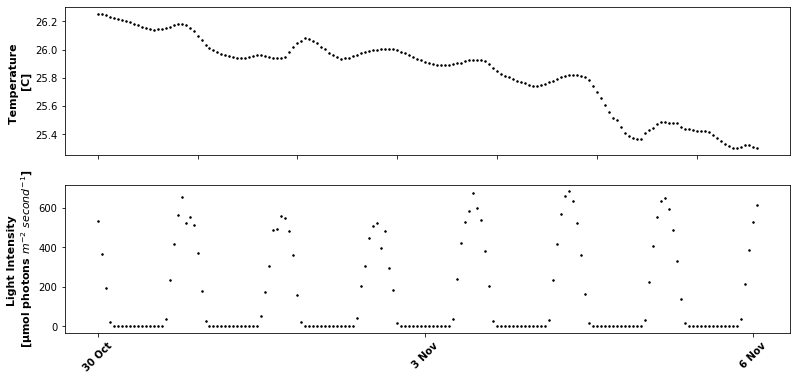

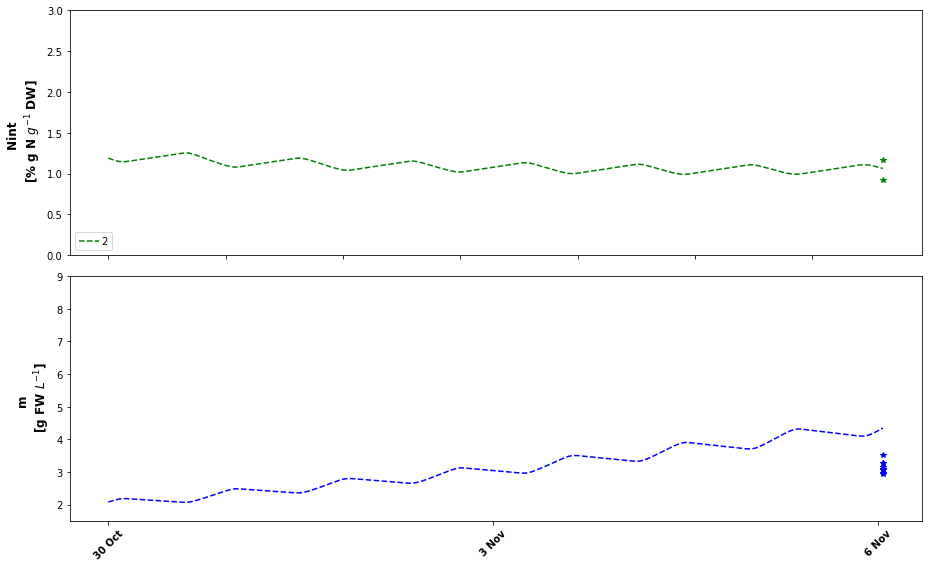

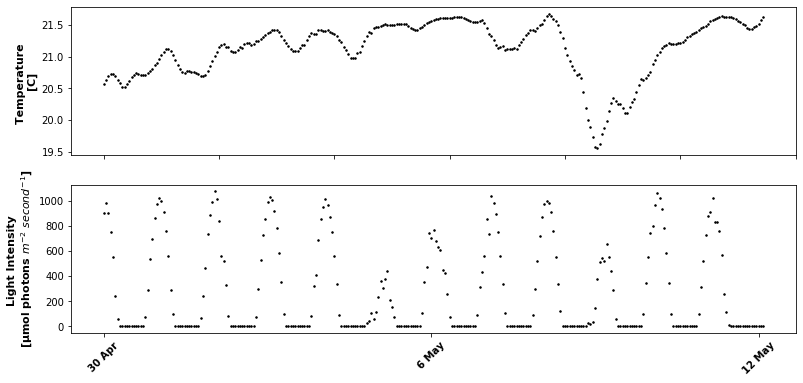

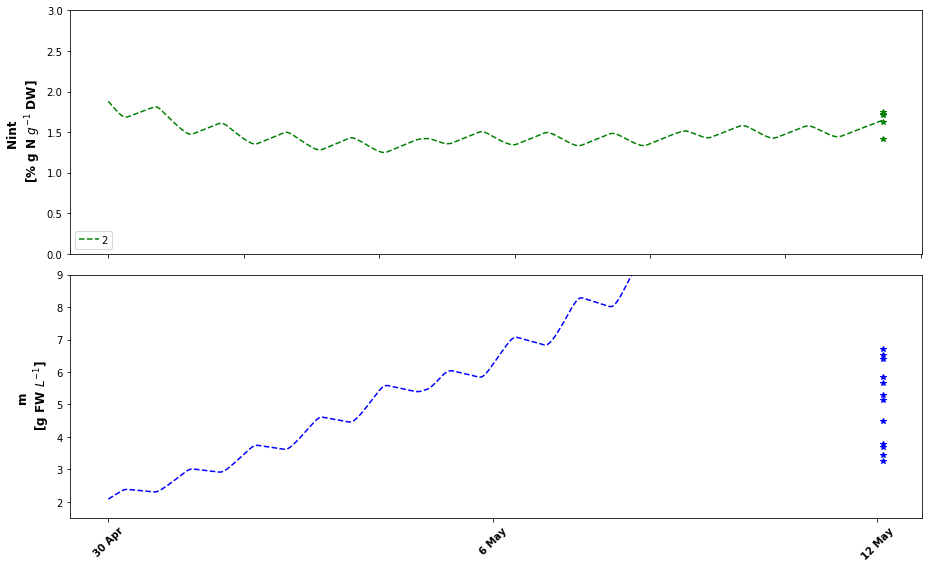

In [18]:
for Next, i in zip(Next_estimate, Experiments):
    print(f" Next, experiment: {Next, i}")
    residual(Next, i, plot_on = True)